# Defining bounding boxes
\
**Goal:** define a bounding box around each of the 5 grounding lines in Greenland from 2017, as defined by [CCI](http://products.esa-icesheets-cci.org/products/downloadlist/GLL/).
\
\
Locations:
- 79 Fjord
- Hagen Brae
- Petermann
- Ryder
- Zachariae Isstrom

In [1]:
from matplotlib import pyplot as plt
import geopandas as gpd
from pathlib import Path
import pandas as pd
from shapely.geometry import Polygon

%matplotlib widget

### Organizing data so that there is one shapefile for each glacier

In [2]:
# combining into one shapefile

data_loc = 'data/greenland_grounding_line_locations_v1_3/Products/Glaciers/'

root_folder = Path(data_loc)
shapefiles = root_folder.rglob("*.shp")
gdfs = []
for shp in shapefiles:
    gdf = gpd.read_file(shp)
    gdfs.append(gdf)

combined_shapefile = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
combined_shapefile.to_file('data/combined_shapefile/combined_glaciers.shp')

In [3]:
# visualizing all GLs
combined_shapefile.explore(tiles='Esri.WorldImagery')

In [4]:
# separating into glaciers

combined_shapefile = gpd.read_file('data/combined_shapefile/combined_glaciers.shp')

fjord79_gls = combined_shapefile[combined_shapefile['glac_name']=='79Fjord Glacier']
hagen_brae_gls = combined_shapefile[combined_shapefile['glac_name']=='Hagen Brae']
petermann_gls = combined_shapefile[combined_shapefile['glac_name']=='Petermann Gletsjer']
ryder_gls = combined_shapefile[combined_shapefile['glac_name']=='Ryder Gletsjer']
zachariae_isstrom_gls = combined_shapefile[combined_shapefile['glac_name']=='Zachariae Isstrom']

### data cleaning

Hagen Brae and Zachariae Isstrom both seem to have undergone major calving events, so the grounding lines are vastly far apart. We are trimming the datasets to only include grounding lines after the major calving.

In [5]:
hagen_brae_all_gls = hagen_brae_gls
hagen_brae_gls = hagen_brae_gls[hagen_brae_gls['proc_date']=='2017-07-07 10:24:20']

In [6]:
zachariae_isstrom_all_gls = zachariae_isstrom_gls
zachariae_isstrom_gls = zachariae_isstrom_gls[zachariae_isstrom_gls['proc_date']=='2017-07-07 09:13:47']

### combining all lines into one geometry for each glacier

In [7]:
fjord79_gls = fjord79_gls.dissolve()
hagen_brae_gls = hagen_brae_gls.dissolve()
petermann_gls = petermann_gls.dissolve()
ryder_gls = ryder_gls.dissolve()
zachariae_isstrom_gls = zachariae_isstrom_gls.dissolve()

### outlining each geometry with the smallest convex polygon

In [8]:
fjord79_polygon = fjord79_gls.convex_hull
hagen_brae_polygon = hagen_brae_gls.convex_hull
petermann_polygon = petermann_gls.convex_hull
ryder_polygon = ryder_gls.convex_hull
zachariae_isstrom_polygon = zachariae_isstrom_gls.convex_hull

### buffering each polygon

In [9]:
buffer_km = 10
buffer_m = buffer_km * 1000

proj_crs = 'epsg:3995'
orig_crs = 'epsg:4326'

fjord79_bbox = fjord79_polygon.to_crs(proj_crs).buffer(buffer_m).to_crs(orig_crs)
hagen_brae_bbox = hagen_brae_polygon.to_crs(proj_crs).buffer(buffer_m).to_crs(orig_crs)
petermann_bbox = petermann_polygon.to_crs(proj_crs).buffer(buffer_m).to_crs(orig_crs)
ryder_bbox = ryder_polygon.to_crs(proj_crs).buffer(buffer_m).to_crs(orig_crs)
zachariae_isstrom_bbox = zachariae_isstrom_polygon.to_crs(proj_crs).buffer(buffer_m).to_crs(orig_crs)

### visualizing bounding boxes

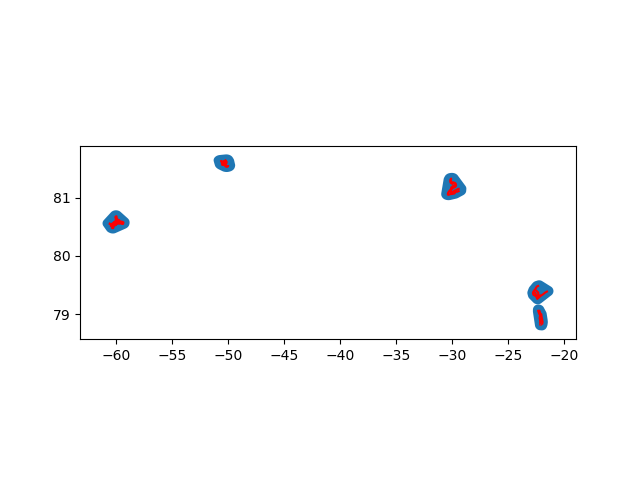

In [10]:
fig,ax=plt.subplots()

fjord79_bbox.plot(ax=ax)
fjord79_gls.plot(ax=ax,color='red')

hagen_brae_bbox.plot(ax=ax)
hagen_brae_gls.plot(ax=ax,color='red')

petermann_bbox.plot(ax=ax)
petermann_gls.plot(ax=ax,color='red')

ryder_bbox.plot(ax=ax)
ryder_gls.plot(ax=ax,color='red')

zachariae_isstrom_bbox.plot(ax=ax)
zachariae_isstrom_gls.plot(ax=ax,color='red')

plt.show()

### saving bboxes as geojson files

In [11]:
data_loc = '../../glacier_gl_bboxes/'

fjord79_bbox.to_file(data_loc + 'fjord79_bbox.json')
hagen_brae_bbox.to_file(data_loc + 'hagen_brae_bbox.json')
petermann_bbox.to_file(data_loc + 'petermann_bbox.json')
ryder_bbox.to_file(data_loc + 'ryder_bbox.json')
zachariae_isstrom_bbox.to_file(data_loc + 'zachariae_isstrom_bbox.json')

# Visualizing the data on GEE

In [18]:
import ee
import geemap

Map = geemap.Map()
Map.add_basemap("Esri.WorldImagery")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [31]:
peterman_ee = geemap.geopandas_to_ee(petermann_gls)
Map.addLayer(peterman_ee, {}, "Petermann")


# Converting the geometry bbox to a gdf
petermann_bbox_gdf = gpd.GeoDataFrame({
    'geometry': petermann_bbox
})

peterman_bbox_ee = geemap.geopandas_to_ee(petermann_bbox_gdf)
Map.addLayer(peterman_bbox_ee, {}, "Petermann_bbox")
